# Section 0 - Package Upload

This code is used for predicting temperature based on data collected from a small lake.

The data originates from high frequency sensors from an urban lake (every 20 mins).

The model predicts temperature of the water for the next 24 hours as it deals only with hourly data.

This European Union Public Licence (the ‘EUPL’) applies to this Work (as defined
below) which is provided under the terms of this Licence.

The Work is provided under the terms of this Licence when the Licensor (as
defined below) has placed the following notice immediately following the
copyright notice for the Work:

        Licensed under the EUPL

or has expressed by any other means his willingness to license under the EUPL.

More information about the license can be found: https://joinup.ec.europa.eu/licence/european-union-public-licence-version-12-or-later-eupl

In [163]:
# pip install -r".\\requirements.txt"

Defaulting to user installation because normal site-packages is not writeable
  Using cached statsmodels-0.13.0-cp39-none-win_amd64.whl (9.4 MB)
     ---------------------------------------- 7.1/7.1 MB 7.2 MB/s eta 0:00:00
     ---------------------------------------- 14.0/14.0 MB 7.0 MB/s eta 0:00:00
     --------------------------------------- 10.2/10.2 MB 38.2 MB/s eta 0:00:00
     ---------------------------------------- 3.2/3.2 MB 12.9 MB/s eta 0:00:00
     -------------------------------------- 62.3/62.3 kB 825.6 kB/s eta 0:00:00
     ---------------------------------------- 33.8/33.8 MB 6.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement skimpy==2.0.5 (from versions: 0.0.2, 0.0.3, 0.0.4, 0.0.5, 0.0.6, 0.0.7, 0.0.8)
ERROR: No matching distribution found for skimpy==2.0.5


In [2]:
import pandas as pd
import requests
import numpy as np 
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import math
import statsmodels as sm
import itertools
import urllib
import csv

from itertools import product
from tqdm import tqdm
from skimpy import skim
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timezone
from dateutil.parser import parse
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split

# Section 1 - Loading the Updated Dataset

## API or loading of the dataset in CSV format

Depending on your dataset, you need to use an API or a csv function to read the data.

In [10]:
df = pd.read_csv('data.csv', delimiter=';') # example

In [11]:
df

,id,temperature,orp,ph,do,ec,battery,sensor_device_id,measured_at,unix_time,created_at,updated_at
0,547c4c9c-39ef-4104-a934-702ad7cbbb64,16.1,6.15,8.31,64.9,1543,100,0004A30B00EF6918,2023-04-24T07:18:54.000000Z,1682320735176,2023-04-24T07:30:12.000000Z,2023-04-24T07:30:12.000000Z
1,24b1221e-7456-4e0a-9ffd-d2427d922b72,16.0,5.89,8.30,62.9,1541,100,0004A30B00EF6918,2023-04-24T06:58:31.000000Z,1682319512168,2023-04-24T07:00:10.000000Z,2023-04-24T07:00:10.000000Z
2,603e9176-4a34-40e0-b675-8ec521aac318,16.0,6.23,8.28,61.3,1538,100,0004A30B00EF6918,2023-04-24T06:38:08.000000Z,1682318289160,2023-04-24T06:45:08.000000Z,2023-04-24T06:45:08.000000Z
3,5686099d-bb05-4b95-904f-bdc4a82f4913,15.9,5.93,8.28,59.7,1537,100,0004A30B00EF6918,2023-04-24T06:17:45.000000Z,1682317066152,2023-04-24T06:30:12.000000Z,2023-04-24T06:30:12.000000Z
4,c596edf8-f17c-4b38-b8c5-ffceebacb7ed,15.9,5.87,8.24,59.3,1539,100,0004A30B00EF6918,2023-04-24T05:57:22.000000Z,1682315843144,2023-04-24T06:00:12.000000Z,2023-04-24T06:00:12.000000Z
...,...,...,...,...,...,...,...,...,...,...,...,...
18976,b1481ed9-aaab-4681-9870-008affaa5ae1,11.7,0.44,652.76,100.0,1,93,0004A30B00EF6918,2022-07-19T06:24:23.000000Z,1658211863706,2022-08-02T06:45:17.000000Z,2022-08-02T06:45:17.000000Z
18977,bdc69a8d-925e-421b-9617-a353bc6b7d7e,11.7,0.44,652.78,100.0,1,93,0004A30B00EF6918,2022-07-19T06:04:00.000000Z,1658210640721,2022-08-02T06:45:17.000000Z,2022-08-02T06:45:17.000000Z
18978,d32af223-d59a-4d97-9ee1-1d69d924341b,11.7,0.44,652.79,100.0,1,93,0004A30B00EF6918,2022-07-19T05:43:37.000000Z,1658209417717,2022-08-02T06:45:17.000000Z,2022-08-02T06:45:17.000000Z
18979,50427607-51e0-47f9-9cb9-a7d75ed59c0a,11.7,0.44,652.78,100.0,1,92,0004A30B00EF6918,2022-07-19T05:23:14.000000Z,1658208194711,2022-08-02T06:45:17.000000Z,2022-08-02T06:45:17.000000Z


In [ ]:
# filter for the sensor under study, in case you have multiple
# df = df[df['sensor_device_id'] == '1'] # change the sensor_id per your indications
df.head(1)

,id,temperature,orp,ph,do,ec,battery,sensor_device_id,measured_at,unix_time,created_at,updated_at
0,547c4c9c-39ef-4104-a934-702ad7cbbb64,16.1,6.15,8.31,64.9,1543,100,0004A30B00EF6918,2023-04-24T07:18:54.000000Z,1682320735176,2023-04-24T07:30:12.000000Z,2023-04-24T07:30:12.000000Z


In [13]:
df['measured_at'] = pd.to_datetime(df['measured_at'])
# extract year, month, day, and hour
df['year'] = df['measured_at'].dt.year
df['month'] = df['measured_at'].dt.month
df['day'] = df['measured_at'].dt.day
df['hour'] = df['measured_at'].dt.hour
df['minutes'] = df['measured_at'].dt.minute
df['seconds'] = df['measured_at'].dt.second

In [14]:
df.set_index('measured_at')

,id,temperature,orp,ph,do,ec,battery,sensor_device_id,unix_time,created_at,updated_at,year,month,day,hour,minutes,seconds
measured_at,,,,,,,,,,,,,,,,,
2023-04-24 07:18:54+00:00,547c4c9c-39ef-4104-a934-702ad7cbbb64,16.1,6.15,8.31,64.9,1543,100,0004A30B00EF6918,1682320735176,2023-04-24T07:30:12.000000Z,2023-04-24T07:30:12.000000Z,2023,4,24,7,18,54
2023-04-24 06:58:31+00:00,24b1221e-7456-4e0a-9ffd-d2427d922b72,16.0,5.89,8.30,62.9,1541,100,0004A30B00EF6918,1682319512168,2023-04-24T07:00:10.000000Z,2023-04-24T07:00:10.000000Z,2023,4,24,6,58,31
2023-04-24 06:38:08+00:00,603e9176-4a34-40e0-b675-8ec521aac318,16.0,6.23,8.28,61.3,1538,100,0004A30B00EF6918,1682318289160,2023-04-24T06:45:08.000000Z,2023-04-24T06:45:08.000000Z,2023,4,24,6,38,8
2023-04-24 06:17:45+00:00,5686099d-bb05-4b95-904f-bdc4a82f4913,15.9,5.93,8.28,59.7,1537,100,0004A30B00EF6918,1682317066152,2023-04-24T06:30:12.000000Z,2023-04-24T06:30:12.000000Z,2023,4,24,6,17,45
2023-04-24 05:57:22+00:00,c596edf8-f17c-4b38-b8c5-ffceebacb7ed,15.9,5.87,8.24,59.3,1539,100,0004A30B00EF6918,1682315843144,2023-04-24T06:00:12.000000Z,2023-04-24T06:00:12.000000Z,2023,4,24,5,57,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-19 06:24:23+00:00,b1481ed9-aaab-4681-9870-008affaa5ae1,11.7,0.44,652.76,100.0,1,93,0004A30B00EF6918,1658211863706,2022-08-02T06:45:17.000000Z,2022-08-02T06:45:17.000000Z,2022,7,19,6,24,23
2022-07-19 06:04:00+00:00,bdc69a8d-925e-421b-9617-a353bc6b7d7e,11.7,0.44,652.78,100.0,1,93,0004A30B00EF6918,1658210640721,2022-08-02T06:45:17.000000Z,2022-08-02T06:45:17.000000Z,2022,7,19,6,4,0
2022-07-19 05:43:37+00:00,d32af223-d59a-4d97-9ee1-1d69d924341b,11.7,0.44,652.79,100.0,1,93,0004A30B00EF6918,1658209417717,2022-08-02T06:45:17.000000Z,2022-08-02T06:45:17.000000Z,2022,7,19,5,43,37


In [15]:
df.drop(columns=['sensor_device_id','unix_time','created_at','updated_at'], inplace=True)

In [16]:
df = df[df['measured_at'] > pd.Timestamp('2022-08-01', tz='UTC')] # in case you change the sensor ID, do not run this!

In [17]:
# in case of null values fill the thing with previous one
# no missing value
df.loc[:].fillna(method='ffill', inplace=True)

## Train and test sets

In [18]:
df['measured_at'] = df['measured_at'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d %H:%M:%S'))
df['time']=df['measured_at']
df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index)

In [19]:
df_hourly= df.resample('h').mean()

In [20]:
df_hourly = df_hourly.dropna()
# splitting the dataset into train and test set in order to optimize the final model
train, test = train_test_split(df_hourly, test_size=0.1, shuffle=False)
train_t=train[['temperature']]
test_t=test[['temperature']]

## Introduction to Time Series Analysis

There are numerous options to temperature prediction, in the case of univariate models. In our case, we used SARIMA model:
* SARIMA is a more complex model composed from multiple elements. It considers the complexity of the trend and seasonality. It leverages the power of  the product method to deal with the complex relationship between different effect components.
   * Averaging methods (MA) predict data based on a constant amount of grouped data points averaged over the course of the series. It includes randomness and it gets rid of short-term fluctuations.
   * Autoregression regression (AR) is a linear model where the coefficients are based the autocorrelation components.
   * ARIMA – combines AR, I and MA. (I) part enables the method to differentiate the series so that it becomes stationary. (MA) part uses the dependency between an observation and the errors from a moving average model and (AR) represents the autoregressive part.
   * SARIMA builds up on ARIMA and adds the seasonality factor.
 
 
In the following lines, we will present SARIMA, given academic and practical proof of its use for temperature predictions.
 
Sources:

ScienceDirect (2023). Moving Average. Retrieved from: https://www.sciencedirect.com/topics/engineering/moving-average#:~:text=A%20moving%20average%20is%20defined,next%20in%20each%20successive%20average. 

Brownlee. Jason (2017, January 9 ). ARIMA for Time Series Forecasting With Python. Machine Learning Mastery. Available at: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/. [Accessed online at 11/04/2023]

Hyndman, R. J., & Athanasopoulos, G. (2018). Forecasting: principles and practice. OTexts. [Accessed online at 11/04/2023]


We will evaluate the model based on several measurements:
 * AIC or  Akaike information criterion estimates the relative quality of a model in comparison with a different model. It doesn't deliver information in absolute terms, but can be interpretated in comparison with alternative models. The lower the value, the better the model.
 * MAE or Mean Absolute Error is a measure of errors between paired data points, one being the prediction and one the actual observations, without considering the direction.
 * MSE or Mean Squared Error is the average of the squared difference between the estimated values and the actual value. It penalizes large errors, whereas MAE doesn't.
 * RMSE is the squared root of MSE. Both RMSE and MSE are highly biased for extreme values, whereas MAE isn't.

# Section 3 - SARIMA

## SARIMA Model - Hourly Data 

Non-seasonal parameters: 
* p = order of the autoregressive part;
* d= degree of first differencing involved;
* q = order of the moving average part.

Seasonal parameters:
* P = seasonal autoregressive part;
* D = seasonal difference/ differencing; 
* Q = seasonal moving average part;
* s = the number of time steps for one season.

* While P and Q may either be integers indicating the AR and MA orders (following the above explanations) or else iterables providing specific AR and/or MA lags to include, D must be an integer representing the integration order of the process. The periodicity (number of seasons) is indicated by the integer s, which is typically 4 for quarterly data or 12 for monthly data. No seasonal effect is the default. In this particular case, the seasonality is 4. 

In [21]:
train, test = train_test_split(df_hourly, test_size=0.1, shuffle=False)
train_t=train[['temperature']] #do, pH
test_t=test[['temperature']] #do, pH

In [22]:
# It checks for the optimal seasonal differencing in a time series data. 
# The function takes two parameters and it delivers the D - seasonal differencing 
# It performs the Adfuller test to check if the data should be adjusted
def check_seasonal_differencing(ts, max_d=5):
    for d in range(max_d+1):
        adf_result = adfuller(ts.diff(d).dropna())
        p_value = adf_result[1]
        if p_value < 0.05:
            break
    if d > 0:
        for D in range(1, 13):
            adf_result = adfuller(ts.diff(D*4).dropna())
            p_value = adf_result[1]
            if p_value < 0.05:
                return D, d
    else:
        return 0, d

In [23]:
D_factor = check_seasonal_differencing(train_t, max_d=2) # this is the seasonal differenciating

In [24]:
# Seasonally moving average part is also derived here:
def check_moving_average(ts):
    seasonal_ma = ts.diff(4)
    acf_vals = acf(seasonal_ma.dropna(), fft=False)
    # Determine order of seasonal moving average component
    Q = 0
    for i in range(1, len(acf_vals)):
        if abs(acf_vals[i]) > 1.96/np.sqrt(len(seasonal_ma)):
            if i % 4 == 0:
                Q = i//4
            else:
                break
    return Q
Q_factor = check_moving_average(train_t) # this is the moving average for the seasonal trend

In [25]:
def optimize_SARIMA(order_list, exog):
    results = []
    for order in tqdm(order_list):
        # fitting the model based on the given assumptions
        # 4 seasons is derived frome expert knowledge
        model_sarima = SARIMAX(exog,order=order,seasonal_order=(0, D_factor[0], Q_factor, 4)).fit(disp=-1)
        ma_params = model_sarima.params[-order[2]:]
        roots = np.roots(np.concatenate(([1], -ma_params)))
        if np.any(np.abs(roots) >= 1):
            continue
        # deriving the AIC
        aic = model_sarima.aic
        # appending the AIC
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

# running now all possible options 
ps = range(0, 10, 1)
ds = range(0, 2, 1)
qs = range(0, 10, 1)
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for p in ps:
    for d in ds:
        for q in qs:
            order_list.append((p, d, q))
result_d = optimize_SARIMA(order_list=order_list, exog=train_t) # Deriving the set of all possible solutions and optimizing it

100%|██████████| 200/200 [38:31<00:00, 11.56s/it]   


In [26]:
SARIMA_optimal = result_d.iloc[0, 0]

## Running SARIMA in order to predict the test set

In [27]:
# fit model
sarima_model = SARIMAX(train_t, order=SARIMA_optimal, seasonal_order=(0, D_factor[0], Q_factor, 4))
sarima_model_fit = sarima_model.fit()
# make prediction
predictions = sarima_model_fit.predict(start=len(train_t), end=len(train_t)+len(test_t)-1)
mae = mean_absolute_error(test_t, predictions)
mse = mean_squared_error(test_t, predictions)
rmse = np.sqrt(mse)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
aic_score = sarima_model_fit.aic
print(f'AIC: {aic_score:.3f}')

MAE: 1.3798522284471477
MSE: 2.847557507113503
RMSE: 1.687470742594817
AIC: -12341.942


## SARIMA Future predictions

In [28]:
temperature =df_hourly[['temperature']]

In [29]:
# fit model
sarima_model = SARIMAX(temperature, 
                       order=SARIMA_optimal, 
                       seasonal_order=(0, D_factor[0], Q_factor, 4))
sarima_model_fit = sarima_model.fit()
# make prediction for the future
predictions = sarima_model_fit.predict(start=len(temperature), end=len(temperature)+23)
aic_score = sarima_model_fit.aic
print(f'AIC: {aic_score:.3f}')

AIC: -13455.572


In [30]:
last_timestamp = pd.to_datetime(temperature.index[-1])
new_index = pd.date_range(start=last_timestamp, periods=25, closed='right', freq='H')
predictions_df = pd.DataFrame(predictions)
predictions_df.index = new_index

## SARIMA Future Predictions - Visualization

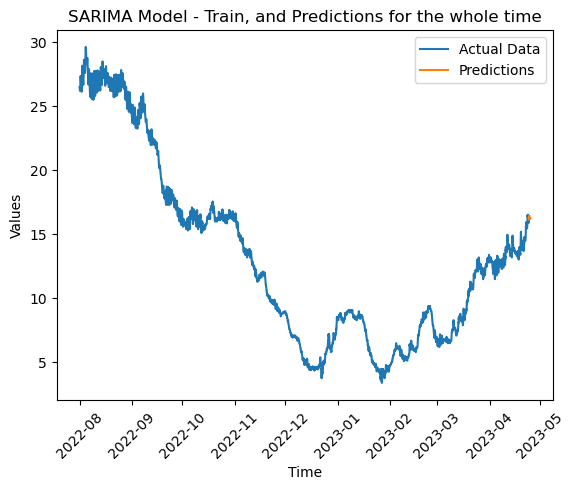

In [31]:
train_series = temperature['temperature']
predictions_series = predictions_df
plt.plot(train_series.index, train_series, label='Actual Data')
plt.plot(predictions_series.index, predictions_series, label='Predictions')
# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('SARIMA Model - Train, and Predictions for the whole time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

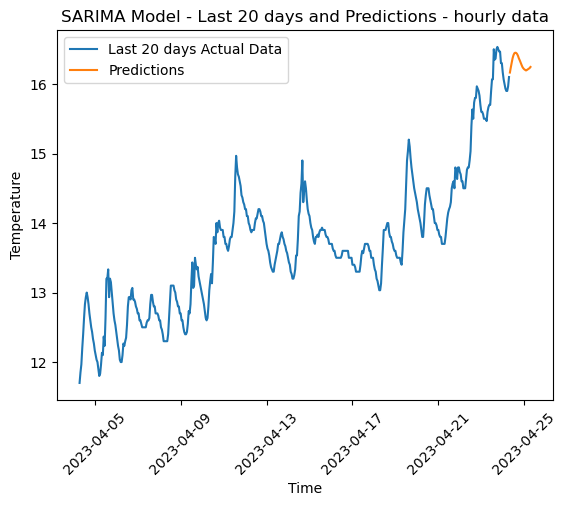

In [32]:
last_date = train_series.index[-1]
one_month_ago = last_date - pd.DateOffset(days=20)
last_month_train_series = train_series[one_month_ago:last_date]
predictions_series = predictions_df
plt.plot(last_month_train_series.index, last_month_train_series, label='Last 20 days Actual Data')
plt.plot(predictions_series.index, predictions_series, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('SARIMA Model - Last 20 days and Predictions - hourly data')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Section 4 - Results

Based on the following analysis, these are the predictions for the next 23 hours:

In [33]:
predictions_df.head(24)

,predicted_mean
2023-04-24 08:00:00,16.164823
2023-04-24 09:00:00,16.237586
2023-04-24 10:00:00,16.305314
2023-04-24 11:00:00,16.370531
2023-04-24 12:00:00,16.414802
2023-04-24 13:00:00,16.442932
2023-04-24 14:00:00,16.450576
2023-04-24 15:00:00,16.447201
2023-04-24 16:00:00,16.432541
2023-04-24 17:00:00,16.406252


This code is free software: you can redistribute it and/or modify it under the terms of the European Union Public License as published by the European Union, under version 1.2. Copyright (c) [2023] [FES Germany].